<a href="https://colab.research.google.com/github/yanamushka/ML-course/blob/main/HW_2_4_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D0%B8_%D0%B1%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3%D1%83_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [2]:
raw_df = pd.read_csv('train.csv')

In [3]:
train_df, val_df = split_train_val(raw_df, 'Exited')

In [4]:
cols = raw_df.columns.drop(['id', 'CustomerId', 'Surname'])

In [5]:
input_cols = [col for col in cols if col != 'Exited']
target_col = 'Exited'


In [6]:
input_train, target_train = separate_inputs_targets(train_df, input_cols=input_cols, target_col = target_col)

In [7]:
input_val, target_val = separate_inputs_targets(val_df, input_cols=input_cols, target_col = target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [8]:
cat_cols = ['Geography', 'Gender']
input_val[cat_cols] = input_val[cat_cols].astype('category')
input_train[cat_cols] = input_train[cat_cols].astype('category')

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [9]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [10]:
!conda install -c conda-forge xgboost

Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [11]:
!pip uninstall -y xgboost

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4


In [12]:
!pip install --no-cache-dir xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 110.1 MB/s eta 0:00:00


In [13]:
from xgboost import XGBClassifier

In [14]:
from sklearn.metrics import roc_auc_score

In [26]:
xgb_clf = XGBClassifier(max_depth = 3,
                        n_estimators = 10,
                        enable_categorical = True,
                        use_label_encoder = False,
                        missing = np.nan,
                        device = 'cuda')
xgb_clf.fit(input_train, target_train)
pred_train = xgb_clf.predict_proba(input_train)[:,1]
pred_val = xgb_clf.predict_proba(input_val)[:,1]
roc_auc_score(target_train, pred_train), roc_auc_score(target_val, pred_val)



/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:18:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(0.934430985513848, 0.933416901022018)

Модель має показник ROC AUC 0.934  на тренувальному наборі даних і 0.933 на валідаційному, що свідчить про хороший рівень генералізації. Бачимо покращення у порівнянні  з показником моделі натренованої за допомогою дерев прийняття рішень.(0.921)

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [16]:
!pip install hyperopt

In [18]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [103]:
from typing_extensions import final
def objective(params):
    clf = xgb.XGBClassifier(
    n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )
    clf.fit(
        input_train,
        target_train,
        eval_set=[(input_val, target_val)],
        verbose=False)
    pred = clf.predict_proba(input_val)[:, 1]
    roc_auc = roc_auc_score(target_val, pred)

    return {'loss': -roc_auc, 'status': STATUS_OK}
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 5),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 3,10,2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0.1, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 50),
    'reg_lambda': hp.uniform('reg_lambda', 10, 50)
}
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)
final_clf.fit(input_train, target_train)
final_pred_train = final_clf.predict_proba(input_train)[:, 1]
final_pred_val = final_clf.predict_proba(input_val)[:,1]
roc_auc_score(target_train, final_pred_train), roc_auc_score(target_val, final_pred_val)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



  5%|▌         | 1/20 [00:00<00:08,  2.21trial/s, best loss: -0.9367319432059813]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:00<00:04,  3.73trial/s, best loss: -0.9367319432059813]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 4/20 [00:01<00:03,  4.68trial/s, best loss: -0.9367319432059813]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:01<00:03,  4.31trial/s, best loss: -0.9367319432059813]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:02<00:03,  3.36trial/s, best loss: -0.9367319432059813]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:02<00:03,  3.84trial/s, best loss: -0.9367319432059813]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:02<00:02,  4.08trial/s, best loss: -0.9367319432059813]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:03<00:02,  3.08trial/s, best loss: -0.9367319432059813]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:03<00:03,  2.18trial/s, best loss: -0.9371263461142739]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 13/20 [00:04<00:02,  2.49trial/s, best loss: -0.9371263461142739]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 15/20 [00:04<00:01,  3.00trial/s, best loss: -0.9371263461142739]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:05<00:00,  3.63trial/s, best loss: -0.9371263461142739]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:05<00:00,  3.24trial/s, best loss: -0.9372203168941627]

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 20/20 [00:06<00:00,  3.14trial/s, best loss: -0.9372203168941627]
Найкращі гіперпараметри:  {'colsample_bytree': 0.7684511990335664, 'gamma': 0.30149954418168645, 'learning_rate': 0.0635149626042915, 'max_depth': 14, 'min_child_weight': 6, 'n_estimators': 185, 'reg_alpha': 7.86139667615594, 'reg_lambda': 46.49663571468813, 'subsample': 0.978488328817998}


/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:43:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(0.9438151342576955, 0.9372203168941627)

Вдалось покращити якість моделі з 0.942 до 0.937 для валідаційного набору даних.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [47]:
%%bash
sudo apt-get update
sudo apt-get install -y build-essential cmake git wget unzip
sudo apt-get install -y libboost-dev libboost-system-dev libboost-filesystem-dev
sudo apt-get install -y libboost-iostreams-dev libboost-program-options-dev libboost-regex-dev
sudo apt-get install -y libboost-thread-dev libboost-chrono-dev libboost-date-time-dev
sudo apt-get install -y libboost-atomic-dev libboost-serialization-dev
sudo apt-get install -y python3-pip

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,317 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,661 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [48]:
%%bash
sudo apt-get install -y ocl-icd-libopencl1 clinfo
sudo apt-get install -y nvidia-opencl-dev opencl-headers

Reading package lists...
Building dependency tree...
Reading state information...
clinfo is already the newest version (3.0.21.02.21-1).
ocl-icd-libopencl1 is already the newest version (2.2.14-3).
ocl-icd-libopencl1 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
nvidia-opencl-dev is already the newest version (11.5.1-1ubuntu1).
The following NEW packages will be installed:
  opencl-headers
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 1,754 B of archives.
After this operation, 12.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 opencl-headers all 3.0~2022.01.04-1 [1,754 B]
Fetched 1,754 B in 0s (6,204 B/s)
Selecting previously unselected package opencl-headers.
(Reading database ... 125788 files and directories currently installed.)
Preparing to unpack .../opencl-headers_3.0~20

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [49]:
%%bash
git clone --recursive https://github.com/microsoft/LightGBM
cd LightGBM
mkdir build
cd build
cmake -DUSE_CUDAP=1 ..
make -j4

Submodule path 'external_libs/compute': checked out '36350b7de849300bd3d72a05d8bf890ca405a014'
Submodule path 'external_libs/eigen': checked out '3147391d946bb4b6c68edd901f2add6ac1f31f8c'
Submodule path 'external_libs/fast_double_parser': checked out '252029ddac664370bdda3f0761675785d92a1573'
Submodule path 'external_libs/fast_double_parser/benchmarks/dependencies/abseil-cpp': checked out 'd936052d32a5b7ca08b0199a6724724aea432309'
Submodule path 'external_libs/fast_double_parser/benchmarks/dependencies/double-conversion': checked out 'f4cb2384efa55dee0e6652f8674b05763441ab09'
Submodule path 'external_libs/fmt': checked out '8303d140a1a11f19b982a9f664bbe59a1ccda3f4'
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI i

Cloning into 'LightGBM'...
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
Cloning into '/content/LightGBM/external_libs/eigen'...
Cloning into '/content/LightGBM/external_libs/fast_double_parser'...
Cloning into '/content/LightGBM/external_libs/fmt'...
Submodule 'benchmark/dependencies/abseil-cpp' (https://github.com/abseil/abseil-cpp.git) registered for path 'external_libs/fast_double_parser/benchmarks/dependencies/abseil-cpp'
Submodule 'benchmark/dependencies/double-conversion' (https://github.com/google/doub

In [51]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [54]:
cat_feature_index = [input_train.columns.get_loc(col) for col in cat_cols]

In [56]:
lgb_clf = lgb.LGBMClassifier(
    max_depth = 6,
    n_estimators = 20,
    learning_rate = 0.1,
    cat_feature = cat_feature_index,
    enable_categorical = True,
    use_label_encoder = False,
    missing = np.nan
)
lgb_clf.fit(input_train, target_train, eval_set = [(input_val, target_val)])
train_pred = lgb_clf.predict_proba(input_train)[:,1]
val_pred = lgb_clf.predict_proba(input_val)[:,1]
roc_auc_score(target_train, train_pred), roc_auc_score(target_val, val_pred)

[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: use_label_encoder
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: u

(0.9428239016280446, 0.9345037382536525)

У порівнянні з моделлю еатренованою на XGBoost результат трішки гірший. Проте на валідаційному наборі показник 0.934 це хороший результат.

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [101]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_split_gain=params['min_split_gain'],
        cat_feature=cat_feature_index,
    )
    clf.fit(
        input_train,
        target_train,
        eval_set=[(input_val, target_val)])
    pred = clf.predict_proba(input_val)[:,1]
    roc_auc = roc_auc_score(target_val, pred)

    return {'loss': -roc_auc, 'status': STATUS_OK}

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)
  }

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])
print("Найкращі гіперпараметри: ", best)

final_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    categorical_feature=cat_feature_index,
    missing=np.nan,
    eval_metric='auc'
)

final_clf.fit(input_train, target_train, eval_set=[(input_val, target_val)], eval_metric='auc')
final_pred_train = final_clf.predict_proba(input_train)[:,1]
final_pred_val = final_clf.predict_proba(input_val)[:,1]
roc_auc_score(target_train, final_pred_train), roc_auc_score(target_val, final_pred_val)

[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

(0.9414017038781632, 0.9366119075382399)

Результат моделі натренованої за допомогою LightGBM на валідаційному наборі цей показник 0.9366 в той час як на XGboost цей показник становив  0.937

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [73]:
cd sample_data/

/content/sample_data


In [85]:
test_df = pd.read_csv('/test.csv')

In [86]:
test_df = test_df.drop(['id', 'CustomerId', 'Surname'], axis = 1)


In [87]:
test_df[cat_cols] = test_df[cat_cols].astype('category')

In [104]:
test_pred = final_clf.predict_proba(test_df)[:, 1]

In [105]:
sample_submission = pd.read_csv('/sample_submission.csv')

In [106]:
sample_submission['Exited'] = test_pred

In [108]:
sample_submission.to_csv('/sample_submissionXGB2.csv', index = False)

Для фінального рішення обрала XGboost так як показник на валідаційному наборі був трі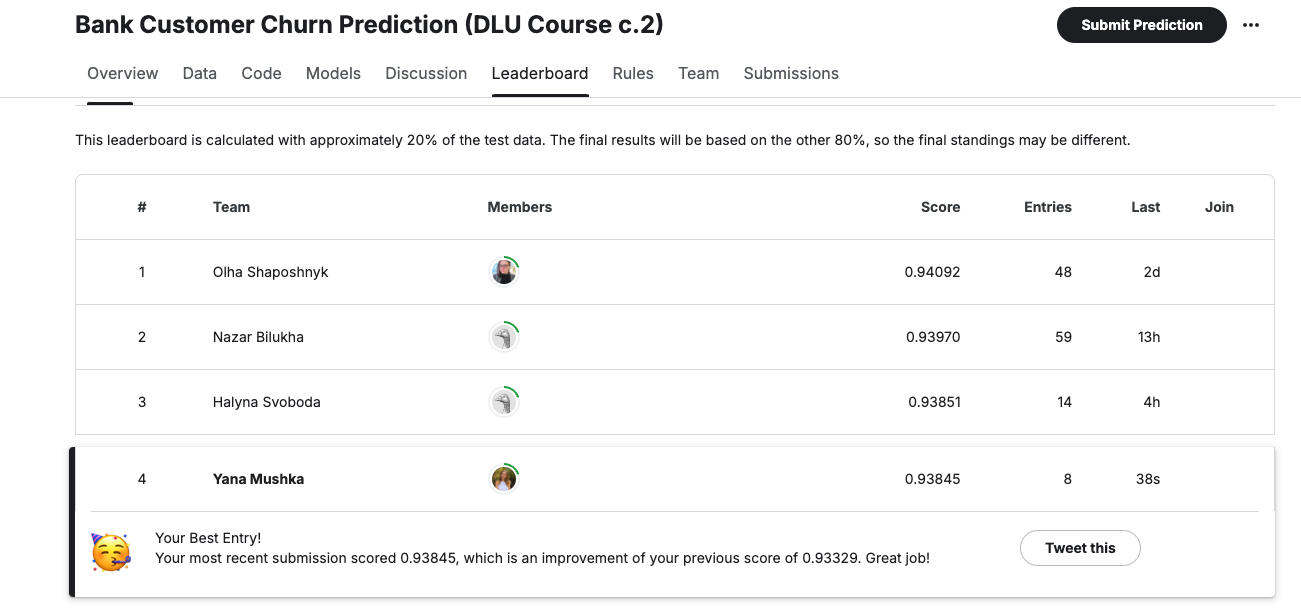шки кращим.